In [4]:
import pickle
import os
import sys
sys.path.insert(0, '../olympus')
sys.path.insert(0, '../graphnet/src')
sys.path.insert(0, '../gnn_testbed')
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.1"

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from tqdm.auto import tqdm

import numpy as np
import seaborn as sns
import random
from jax import random
from jax import numpy as jnp

import torch
import torch_cluster
import torch_geometric
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from nemesis.event_generation.detector import make_line, generate_noise, Detector, make_triang
from nemesis.plotting import plot_event, plot_events, plot_confusion
from nemesis.data_handling.utils import event_labelling
from nemesis.node_features.feature_generation import generate_features
from nemesis.evaluation.evaluation import model_evaluation, energy_division_loaders, energy_evaluation
from nemesis.evaluation.utils import count_parameters
from nemesis.models.train import train_model
from nemesis.models.gnns import Dynamic_class, DynEdge_modified, Dyn_own

from torch.nn import Linear, Identity, ReLU, Softmax, Dropout, LeakyReLU
import torch.nn.functional as F
from torch_geometric.nn import knn_graph, TAGConv, global_mean_pool, global_max_pool, BatchNorm,  global_add_pool, EdgeConv, DynamicEdgeConv

from graphnet.models.gnn.dynedge import DynEdge
from graphnet.components.layers import DynEdgeConv
from graphnet.models.gnn.gnn import GNN
from graphnet.models.utils import calculate_xyzt_homophily, calculate_xyz_homophily_POne

%matplotlib inline


In [5]:
outpath = "."
plt.rcParams['figure.dpi'] = 100
if torch.cuda.is_available():
    print('CUDA')
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print('CPU')

CUDA


In [6]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
pmts_per_module = 16
pmt_cath_area_r = 75E-3 / 2 # m
module_radius = 0.21 # m
v_x = 0
efficiency = pmts_per_module * (pmt_cath_area_r)**2 * np.pi / (4*np.pi*module_radius**2)
det = make_triang(side_len, oms_per_line, dist_z, dark_noise_rate, rng, efficiency=efficiency, v_x=v_x, buoy_weight=30)
module_positions = jnp.asarray(det.module_coords)

In [4]:
def load_all_events(it):
    path_to_events = "/dss/pone/pone_events/all_events"
    load_array = ['cascades_15000ev_3.5-6.5_1.pickle',  'cascades_15000ev_3.5-6.5_2.pickle',
                  'cascades_15000ev_3.5-6.5_3.pickle',  'cascades_15000ev_3.5-6.5_4.pickle',
                  'stracks_15000ev_3.5-6.5_1.pickle',   'stracks_15000ev_3.5-6.5_2.pickle', 
                  'stracks_15000ev_3.5-6.5_3.pickle',   'stracks_15000ev_3.5-6.5_4.pickle', 
                  'tracks_15000ev_3.5-6.5_1.pickle',    'tracks_15000ev_3.5-6.5_2.pickle', 
                  'tracks_15000ev_3.5-6.5_3.pickle',    'tracks_15000ev_3.5-6.5_4.pickle']
            
    events, records = pickle.load(open(os.path.join(path_to_events, load_array[it]), "rb"))
    
    print(f'{it} loaded!')
    
    return events, records

In [ ]:
Radius = 100
k = 15
cascade_labels, track_labels, strack_labels = event_labelling(track_records, strack_records, cascade_records, det_hull=(Radius,1000))
all_events = cascades + tracks + stracks
all_records = cascade_records + track_records + strack_records
all_labels = cascade_labels + track_labels + strack_labels
data_array = generate_features(det, all_events, all_labels, k=k)
pickle.dump(data_array,open(f"/dss/pone/pone_events/features_arrays/data_array_{180}k_k{k}_R{Radius}.pickle", "wb"))

In [7]:
Radius = 'out' #100, 75
k=15
data_array = pickle.load(open(f"/dss/pone/pone_events/features_arrays/data_array_{180}k_k{k}_R{Radius}.pickle", "rb"))

In [12]:
from nemesis.models.gnns import MLP
class Dynamic_class(torch.nn.Module):
    
    def __init__(self, out_channels, k, aggr='max', bigMLP=True):
        super().__init__()

        self.conv11 = TAGConv(15, 64, K=4)
        self.conv12 = TAGConv(64, 64, K=4)
        self.BatchNorm1 = BatchNorm(64)

        if bigMLP:
            b = [64, 64, 32]
            c = [2*32, 64, 64]
            d = [2*64, 32, 32]
        else:
            b = [64, 128, 128]
            c = [2*128, 64, 64]
            d = [2*64, 128, 128]
            
        self.conv21 = TAGConv(b[0], b[1], K=3)
        self.conv22 = TAGConv(b[1], b[2], K=3)
        self.BatchNorm2 = BatchNorm(b[2])

        self.conv31 = DynamicEdgeConv(Linear(c[0], c[1]), k, aggr)        
        self.conv32 = DynamicEdgeConv(Linear(c[1]*2, c[2]), k, aggr)
        self.BatchNorm3 = BatchNorm(c[2])

        self.conv41 = DynamicEdgeConv(Linear(d[0], d[1]), k, aggr)
        self.conv42 = DynamicEdgeConv(Linear(2*d[1], d[2]), k, aggr)
        self.BatchNorm4 = BatchNorm(d[2])
        
        if bigMLP:
            self.lin1 = Linear((64*2 + 32*2), 128)
            self.mlp = MLP([128, 32, out_channels], dropout=0.5)
        else:
            self.lin1 = Linear((64*2 + 128*2), 2048)
            self.mlp = MLP([2048, 2048, 1024, 1024, 512, 512, 256, 256, out_channels], dropout=0.5)


    def forward(self, x):#, edge_index, batch):
        x, edge_index, batch = x.x, x.edge_index, x.batch
        x1 = self.conv11(x, edge_index).relu()
        x1 = self.conv12(x1, edge_index).relu()
        x1 = self.BatchNorm1(x1)
        x11 = global_max_pool(x1, batch)        

        x2 = self.conv21(x1, edge_index).relu()
        x2 = self.conv22(x2, edge_index).relu()
        x2 = self.BatchNorm2(x2)
        x21 = global_max_pool(x2, batch)

        x3 = self.conv31(x2, batch)
        x3 = self.conv32(x3, batch)
        x3 = self.BatchNorm3(x3)
        x31 = global_max_pool(x3, batch)

        x4 = self.conv41(x3, batch)
        x4 = self.conv42(x4, batch)
        x4 = self.BatchNorm4(x4)
        x41 = global_max_pool(x4, batch)
    
        out = self.lin1(torch.cat([x11, x21, x31, x41], dim=1))


        out = self.mlp(out)
        return F.log_softmax(out, dim=1)

/home/work/.local/lib/python3.10/site-packages/pytorch_lightning/core/lightning.py:22: LightningDeprecationWarning: pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.core.module.LightningModule class instead.
  rank_zero_deprecation(


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 000, Train Acc: 0.7922, Val Acc: 0.8662, patience: 0
Epoch: 001, Train Acc: 0.8778, Val Acc: 0.8805, patience: 1
Epoch: 002, Train Acc: 0.8923, Val Acc: 0.8919, patience: 1
Epoch: 003, Train Acc: 0.9009, Val Acc: 0.9020, patience: 1
Epoch: 004, Train Acc: 0.9076, Val Acc: 0.8975, patience: 1
Epoch: 005, Train Acc: 0.9115, Val Acc: 0.9130, patience: 2
Epoch: 006, Train Acc: 0.9145, Val Acc: 0.9126, patience: 1
Epoch: 007, Train Acc: 0.9184, Val Acc: 0.9184, patience: 2
Epoch: 008, Train Acc: 0.9201, Val Acc: 0.9164, patience: 1
Epoch: 009, Train Acc: 0.9214, Val Acc: 0.9163, patience: 2
Epoch: 010, Train Acc: 0.9240, Val Acc: 0.9157, patience: 3
Epoch: 011, Train Acc: 0.9257, Val Acc: 0.9183, patience: 4
Epoch: 012, Train Acc: 0.9275, Val Acc: 0.9176, patience: 5
Epoch: 013, Train Acc: 0.9280, Val Acc: 0.9187, patience: 6
Epoch: 014, Train Acc: 0.9305, Val Acc: 0.9196, patience: 1
Epoch: 015, Train Acc: 0.9319, Val Acc: 0.9232, patience: 1
Epoch: 016, Train Acc: 0.9344, Val Acc: 

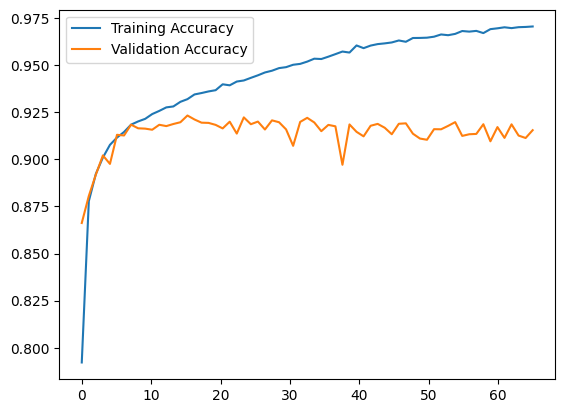

In [8]:
import random
random.seed(982356)

indices = np.arange(len(data_array))
random.shuffle(indices)


shuffled_data = [data_array[i] for i in indices]
split_test = int(len(shuffled_data)*0.95)
training_data = shuffled_data[:split_test]
split_val = int(len(training_data)*0.9)
train_dataset = training_data[:split_val]
val_dataset = training_data[split_val:]

test_dataset = shuffled_data[split_test:]
test_indices = indices[split_test:]

epochs = 250
patience=50
batch_size=250
lr=0.001
layer_size_scale = 4
print_step = 1
#model = DynEdge_modified(15, 4, k = k, features_subset = slice(12, 15), layer_size_scale=layer_size_scale)
model = Dyn_own(15, 4, k=15, feat_subset=slice(12, 15))
model.to(device)
label_map = {0:"Contained cascade", 1:'Throughgoing Track', 2:"Starts in detector", 3:"Rest of events"}
model, all_trains_acc, all_vals_acc = train_model(model, train_dataset, val_dataset, label_map, k=k, epochs=epochs, patience=patience, print_step=print_step, batch_size=batch_size, lr=lr)
plt.plot(np.linspace(0, len(all_trains_acc), len(all_trains_acc)), all_trains_acc, label="Training Accuracy")
plt.plot(np.linspace(0, len(all_vals_acc), len(all_vals_acc)), all_vals_acc, label="Validation Accuracy")
plt.legend()
plt.show()

In [2]:
model

NameError: name 'model' is not defined

In [1]:
import os
from datetime import datetime

path_to_models = "/dss/pone/nemesis_trained_models/"
a = datetime.now()
today_folder = f'{a.strftime("%b")}{a.day}/'
n_events = len(data_array)
R=100
k=15
layer_size_scale=4
lr=0.001
n_events=len(data_array)
batch_size=250
model_name = "Dyn_own"

filename = f'{model_name}_{int(n_events/1000)}k_R{R}_k{k}_B{batch_size}_L{layer_size_scale}_lr{lr}.pt'

path_to_save = os.path.join(path_to_models, today_folder)
if os.path.isdir(path_to_save):
    
    if os.path.isfile(os.path.join(path_to_save, filename)):
        print(f"file {filename} already exist")
    else:
        torch.save(model, os.path.join(path_to_save, filename))
else:
    os.makedirs(path_to_save)
    torch.save(model, os.path.join(path_to_save, filename))

NameError: name 'data_array' is not defined

In [ ]:
det, cascades_test, cascade_records_test, tracks_test, track_records_test, stracks_test, strack_records_test = all_ev
cascade_labels_test, track_labels_test, strack_labels_test = event_labelling(track_records_test, strack_records_test, cascade_records_test, det_hull=[500, 1000])
all_events_test = cascades_test + tracks_test + stracks_test
all_records_test = cascade_records_test + track_records_test + strack_records_test
all_labels_test = cascade_labels_test + track_labels_test + strack_labels_test

In [ ]:
gaps_to_evaluate = energy_gap_test(det, model, all_events_test, all_records_test, all_labels_test, num_divisions=10, k=8)
energy_divisions = gaps_to_evaluate.energy_division_loaders()
fig, test_accuracies, misscls_idx = gaps_to_evaluate.energy_evaluation()

In [158]:

import torch
import torch_geometric
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from nemesis.node_features.feature_generation import get_features
from torch_geometric.loader import DataLoader
from torch_geometric.nn import knn_graph
class energy_gap_test():
    
    def __init__(self, det, model, all_events_test, all_records_test, all_labels_test, num_divisions:int, k:int):
        self.det = det
        self.model = model
        self.all_events_test = all_events_test
        self.all_records_test = all_records_test
        self.all_labels_test = all_labels_test
        self.k = k
        self.num_divisions = num_divisions
        
    def energy_division_loaders(self, log_emin=None, log_emax=None):
        #Create the energy bins
        if log_emin and log_emax:
            #Emin = np.power(10, log_emin)
            #Emax = np.power(10, log_emax)
            energy_divisions = np.logspace(log_emin, log_emax, self.num_divisions)
            #energy_divisions = np.linspace(Emin, Emax, num_divisions)
        else:
            all_energies = [sub.mc_info[0]['energy'] for sub in self.all_records_test]
            energy_divisions = np.linspace(np.min(all_energies), np.max(all_energies), self.num_divisions)
        
        len_divisions = 0
        #Create dict with the index of the events for each energy division
        interval_dict = {}
        
        for interval_nr in range(len(energy_divisions)-1):
            interval_dict[f"interval{interval_nr}"] = []
            count = 0
            for nr,rc in enumerate(self.all_records_test):
                if rc.mc_info[0]['energy'] >= energy_divisions[interval_nr] and rc.mc_info[0]['energy'] < energy_divisions[interval_nr+1]:
                    count+=1
                    #print(energy_divisions[interval_nr+1])
                    interval_dict[f"interval{interval_nr}"].append(nr)
            len_divisions+=count


        pbar = tqdm(total=len(self.all_labels_test))
        test_energy_loaders = []

        #Generate the test energy loaders for each energy division
        for int_nr, interval in enumerate(interval_dict):
            data_array = []
            for ev in interval_dict[interval]:
                features = get_features(self.det, self.all_events_test[ev])
                valid = np.all(np.isfinite(features), axis=1)
                features = features[valid]
                x = torch.Tensor(features)
                
                edge_index = knn_graph(x[:, [-1, -2, -3]], k=self.k, loop=False)
                #data = transf(torch_geometric.data.Data(x, edge_index, y=torch.tensor([label], dtype=torch.int64)).to(device))
                data = torch_geometric.data.Data(x, edge_index, y=torch.tensor(self.all_labels_test[ev], dtype=torch.int64)).to(device)
                data_array.append(data)
                pbar.update()
            loader = DataLoader(data_array)
            test_energy_loaders.append(loader)
            self.test_energy_loaders = test_energy_loaders
            self.energy_divisions = energy_divisions
            
        return energy_divisions


    def energy_evaluation(self, plot_conf=True, label_map = {0:"Contained cascade", 1:'Throughgoing Track', 2:"Starts in detector", 3:"Rest of events"}):    
        
        nplt = int(np.ceil(np.sqrt(len(self.test_energy_loaders))))
        fig = plt.figure(figsize=(nplt * 4, nplt * 4))
        pbar = tqdm(total=len(self.test_energy_loaders))
        test_accuracies = []

        ## Checking for predictions
        with torch.no_grad():
            for i, loader in enumerate(self.test_energy_loaders):
                test_preds = []
                test_truths = []
                test_scores = []
                all_preds_test_len = 0
                
                for data in loader:  # Iterate in batches over the training/test dataset.
                    out = self.model(data)
                    #print(out.shape)
                    test_pred = out.argmax(dim=1)
                    test_preds.append(test_pred)
                    test_truths.append(data.y)
                    test_scores.append(out)
                    all_preds_test_len+=len(data.y)
                    
                test_preds = torch.cat(test_preds).cpu()
                test_truths = torch.cat(test_truths).cpu()
                test_scores = torch.cat(test_scores).cpu()
                misscls_idx = np.atleast_1d(np.argwhere(test_preds != test_truths).ravel())
                test_accuracy = 100 * (all_preds_test_len - len(misscls_idx)) / all_preds_test_len
                all_preds = []
                
                for j in range(len(label_map)):
                    true_sel = test_truths == j
                    predictions = np.histogram(test_preds[true_sel], bins=np.arange(0, len(label_map)+1, 1))[0]
                    if predictions.sum() == 0:
                        predictions = predictions
                    else:
                        predictions = predictions / predictions.sum()
                    all_preds.append(predictions)
                    
                all_preds = np.vstack(all_preds)
                test_accuracies.append(test_accuracy)
                
                if plot_conf:
                    ax = fig.add_subplot(nplt, nplt, i + 1)
                    ax1 = sns.heatmap(all_preds, cmap=plt.cm.Blues, annot=True, ax=ax)# xticklabels=list(label_map.values()), yticklabels=list(label_map.values()), ax=ax)
                    ax1.set_xlabel("Predicted Label")
                    ax1.set_ylabel("True Label")
                #ax1.set_title()
                #fig1 = ax.get_figure()
                pbar.update()
                ax, ax1 = 0,0
                
                
        plt.show()
        self.test_accuracies = test_accuracies
        print('The accuracies of the different energy divisions are', test_accuracies)
        
        return fig, misscls_idx
        
    def plot_energy_accuracies(self):
        # calculate the widths of the intervals
        widths = np.diff(self.energy_divisions)

        # create a figure and axis object
        fig3, ax3 = plt.subplots()

        # plot the histogram of function values for each interval
        ax3.bar(self.energy_divisions[:-1], self.test_accuracies, width=widths, align='edge')

        # set the x and y axis labels
        ax3.set_xlabel('Intervals')
        ax3.set_ylabel('Function Values')

        # show the plot
        plt.show()
        return fig3

In [163]:
gaps_to_evaluate = energy_gap_test(det, model, all_events_test, all_records_test, all_labels_test, num_divisions=15, k=15)
energy_divisions = gaps_to_evaluate.energy_division_loaders()


  0%|          | 0/4500 [00:00<?, ?it/s]

In [164]:
fig, misscls_idx = gaps_to_evaluate.energy_evaluation()

  0%|          | 0/14 [00:00<?, ?it/s]

The accuracies of the different energy divisions are [60.207612456747405, 76.02591792656588, 73.74517374517374, 75.0, 77.24137931034483, 82.47422680412372, 82.27848101265823, 75.32467532467533, 72.1311475409836, 74.13793103448276, 60.78431372549019, 88.63636363636364, 75.60975609756098, 92.10526315789474]


In [175]:
def plot_energy_accuracies(energy_divisions, test_accuracies):
    # calculate the widths of the intervals
    widths = np.diff(energy_divisions,0)

    # create a figure and axis object
    fig3, ax3 = plt.subplots()

    # plot the histogram of function values for each interval
    ax3.bar(energy_divisions[:-1], test_accuracies, width=widths, align='edge')

    # set the x and y axis labels
    ax3.set_xlabel('Intervals')
    ax3.set_ylabel('Function Values')

    # show the plot
    plt.show()
    return fig3

In [202]:
%matplotlib inline

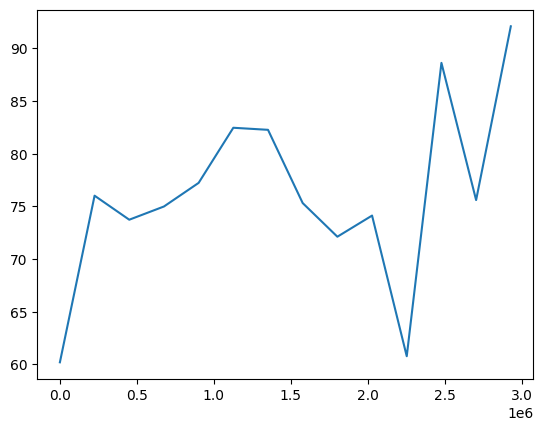

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (14, 1) and arg 2 with shape (15, 1).

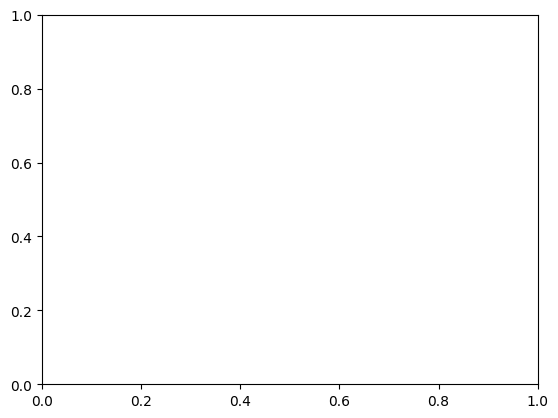

In [204]:
fig3 = plot_energy_accuracies(energy_divisions, test_accuracies)

In [ ]:
fig3

In [118]:
import numpy as np
import matplotlib.pyplot as plt

def plot_intervals_histogram(intervals, function_values):
    # calculate the widths of the intervals
    widths = np.diff(intervals)

    # create a figure and axis object
    fig, ax = plt.subplots()

    # plot the histogram of function values for each interval
    ax.bar(intervals[:-1], function_values, width=widths, align='edge')

    # set the x and y axis labels
    ax.set_xlabel('Intervals')
    ax.set_ylabel('Function Values')

    # show the plot
    plt.show()
    return fig
    

In [119]:
    
intervals = [0, 1, 2, 3, 4]
function_values = [1, 2, 3, 4]

fig = plot_intervals_histogram(intervals, function_values)

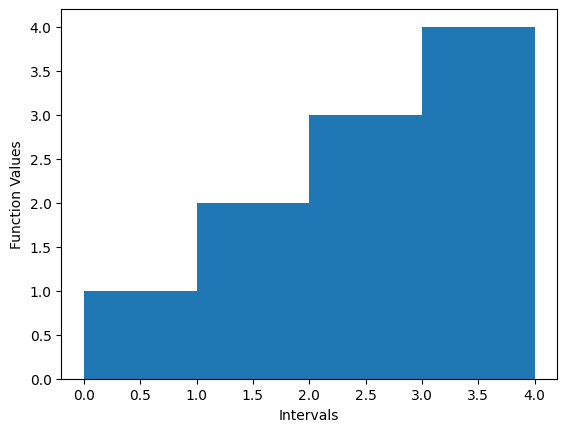

In [120]:
fig